Importing Libraries

In [ ]:
# Importing necessary libraries for data manipulation, visualization, and machine learning.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Loading Data


In [ ]:
# Reading electricity and weather data from CSV files.
electric_data = pd.read_csv('/content/electric_demand_combined.csv')
weather_data = pd.read_csv('/content/weather_combined.csv')

Dropping Unnecessary Columns


In [ ]:
electric_data = electric_data.drop(columns=['Unnamed: 0', 'respondent', 'respondent_name', 'value_units'])
weather_data = weather_data.drop(columns=['Unnamed: 0', 'station', 'text_description', 'longitude', 'latitude'])
# Removed columns that are not relevant to analysis or modeling.
# This step reduces the dimensionality of the dataset and avoids redundant information.


Handling Date-Time Columns


In [ ]:
# Convert timestamp in weather data to datetime format with UTC
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], utc=True)
weather_data.rename(columns={'timestamp': 'Date', 'temperature_c': 'Temperature', 'dewpoint_c': 'Dewpoint', 'wind_speed_kmh': 'WindSpeed', 'wind_direction': 'WindDirection', 'relative_humidity': 'Humidity', 'visibility_m': 'Visibility'}, inplace=True)

# Convert period in electricity data to datetime format without timezone
electric_data['period'] = pd.to_datetime(electric_data['period'], format='%Y-%m-%dT%H')
electric_data['Date'] = electric_data['period'].dt.tz_localize('UTC')
electric_data.rename(columns={'demand': 'ElectricityDemand', 'day_ahead_demand_forecast': 'DayAheadForecast'}, inplace=True)
electric_data.drop(columns=['period'], inplace=True)


Merging Datasets


In [ ]:
# Merge the datasets on the 'Date' column
data = pd.merge(electric_data, weather_data, on='Date', how='inner')

# Combining electricity and weather data on the 'Date' column using an inner join.
# Ensures only rows with matching dates in both datasets are included.

Exploring Data


In [ ]:
print("Data Head:")
print(data.head())
print("\nData Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())


# Displaying the first few rows, dataset information, and count of missing values.
# Provides an overview of the dataset and helps identify missing data.

Data Head:
   DayAheadForecast  ElectricityDemand  net_generation  total_interchange  \
0           83129.0            84761.0             NaN                NaN   
1           83129.0            84761.0             NaN                NaN   
2           69295.0            76134.0         83763.0             7632.0   
3           63377.0            66486.0         74648.0             8165.0   
4           63817.0            65866.0         73798.0             7935.0   

                       Date  Temperature  Dewpoint  WindSpeed  WindDirection  \
0 2024-05-17 13:00:00+00:00         17.8      17.2        0.0            0.0   
1 2024-05-17 13:00:00+00:00         17.8      17.2        0.0            0.0   
2 2023-10-01 04:00:00+00:00         13.9      13.9        0.0            0.0   
3 2023-10-01 08:00:00+00:00         15.0      13.3        0.0            0.0   
4 2023-10-01 09:00:00+00:00         11.7       NaN        0.0            0.0   

     Humidity  Visibility  
0   96.284527    

#Handling Missing Values
Method 1 Dropping Null Values

In [ ]:
# Drop rows with null values in specified columns
columns_to_drop_null = [
    'ElectricityDemand', 'net_generation', 'total_interchange',
    'Temperature', 'Dewpoint', 'WindSpeed', 'WindDirection', 'Humidity'
]

# Drop rows where any of these columns have null values
data = data.dropna(subset=columns_to_drop_null)

# Removes rows with missing values in critical columns for a cleaner dataset.
# Pros: Ensures no missing data.
# Cons: Potential loss of valuable data if many rows are dropped.


Feature Engineering


In [ ]:
# Extract time-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Derives additional time-based features for analysis and modeling.
# Helps capture patterns like seasonality, weekends, and weekdays.

Exploratory Data Analysis (EDA)

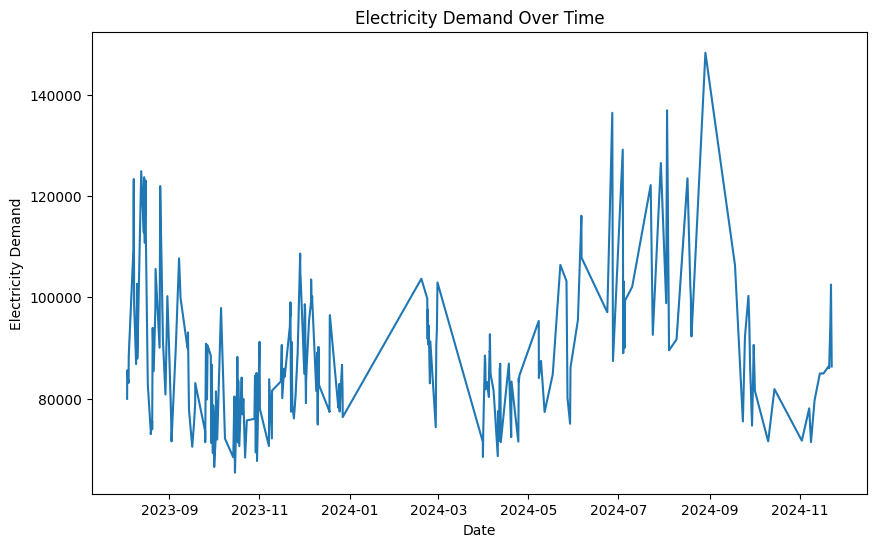

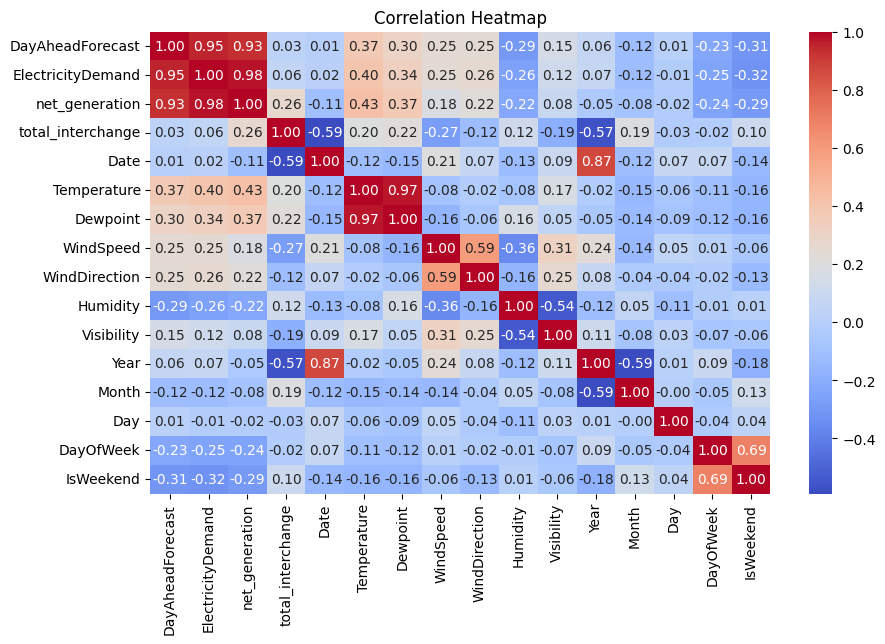

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='ElectricityDemand', data=data)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


# Visualizes the time trends and correlation between features.
# Provides insights into demand patterns and relationships between variables.

Preparing Data for Modeling


In [ ]:
features = ['Temperature', 'Humidity', 'WindSpeed', 'Year', 'Month', 'Day', 'DayOfWeek', 'IsWeekend']
X = data[features]
y = data['ElectricityDemand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Selects features for modeling and splits the data into training and testing sets.
# Ensures reproducibility with a random state.

Model Training


In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Trains a Random Forest Regressor using the training data.
# Random forests are robust and handle non-linear relationships well

RandomForestRegressor(random_state=42)

Model Evaluation


In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")


# Evaluates the model using RMSE, MAE, and R2 score metrics.
# Provides an understanding of model performance.


RMSE: 6196.018360282781
MAE: 3887.1844870129867
R2 Score: 0.7879557264795601


Visualizing Predictions


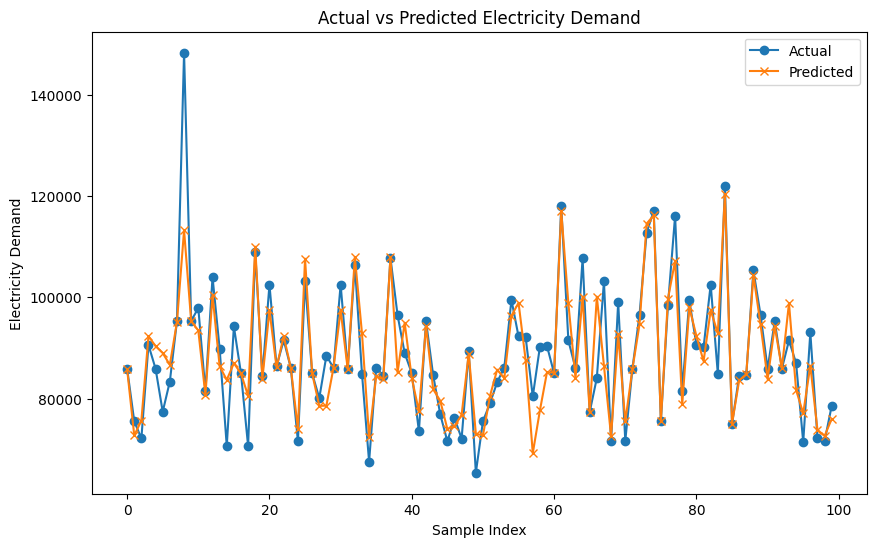

In [ ]:
# Step 9: Visualization of Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Sample Index')
plt.ylabel('Electricity Demand')
plt.legend()
plt.show()


# Compares actual and predicted values for electricity demand visually.
# Helps identify discrepancies and assess prediction accuracy.

#Method 2 By Filling Null Values



In [ ]:
# Load data
electricity_data = pd.read_csv('/content/electric_demand_combined.csv')
weather_data = pd.read_csv('/content/weather_combined.csv')

In [ ]:
# Drop unnecessary columns
electricity_data = electricity_data.drop(columns=['Unnamed: 0', 'respondent', 'respondent_name', 'value_units'])
weather_data = weather_data.drop(columns=['Unnamed: 0', 'station', 'text_description', 'longitude', 'latitude'])

In [ ]:
# Convert timestamp in weather data to datetime format with UTC
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], utc=True)
weather_data.rename(columns={'timestamp': 'Date', 'temperature_c': 'Temperature', 'dewpoint_c': 'Dewpoint',
                             'wind_speed_kmh': 'WindSpeed', 'wind_direction': 'WindDirection',
                             'relative_humidity': 'Humidity', 'visibility_m': 'Visibility'}, inplace=True)

# Convert period in electricity data to datetime format without timezone
electricity_data['period'] = pd.to_datetime(electricity_data['period'], format='%Y-%m-%dT%H')
electricity_data['Date'] = electricity_data['period'].dt.tz_localize('UTC')
electricity_data.rename(columns={'demand': 'ElectricityDemand', 'day_ahead_demand_forecast': 'DayAheadForecast'}, inplace=True)
electricity_data.drop(columns=['period'], inplace=True)


In [ ]:
# Merge the datasets on the 'Date' column
data = pd.merge(electricity_data, weather_data, on='Date', how='inner')

In [ ]:
#Data Cleaning
# Handle missing values
data['ElectricityDemand'] = data['ElectricityDemand'].fillna(data['ElectricityDemand'].mean())
data['net_generation'] = data['net_generation'].fillna(data['net_generation'].mean())
data['total_interchange'] = data['total_interchange'].fillna(data['total_interchange'].mean())
data['Temperature'] = data['Temperature'].fillna(data['Temperature'].mean())
data['Humidity'] = data['Humidity'].fillna(data['Humidity'].mean())
data['WindSpeed'] = data['WindSpeed'].fillna(data['WindSpeed'].mean())
data['Dewpoint'] = data['Dewpoint'].fillna(data['Dewpoint'].mean())
data['WindDirection'] = data['WindDirection'].fillna(data['WindDirection'].mode()[0])

In [ ]:
# Extract time-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

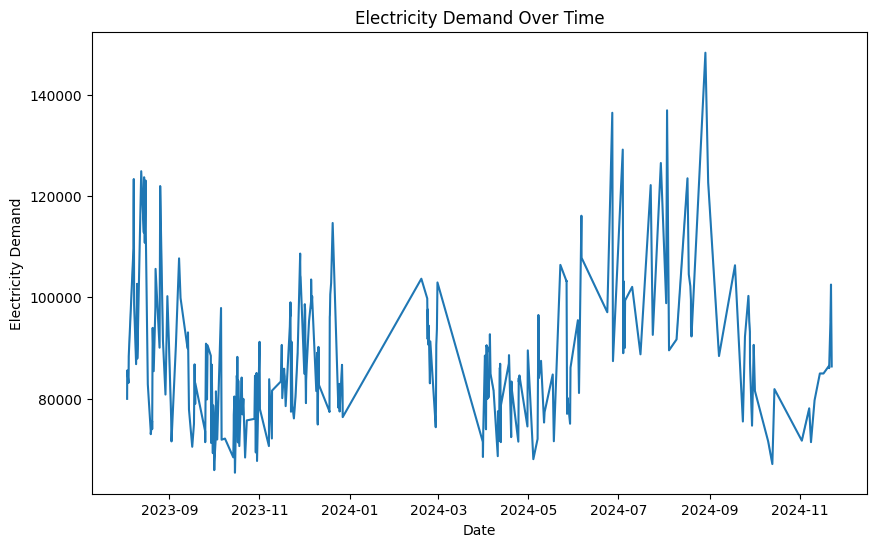

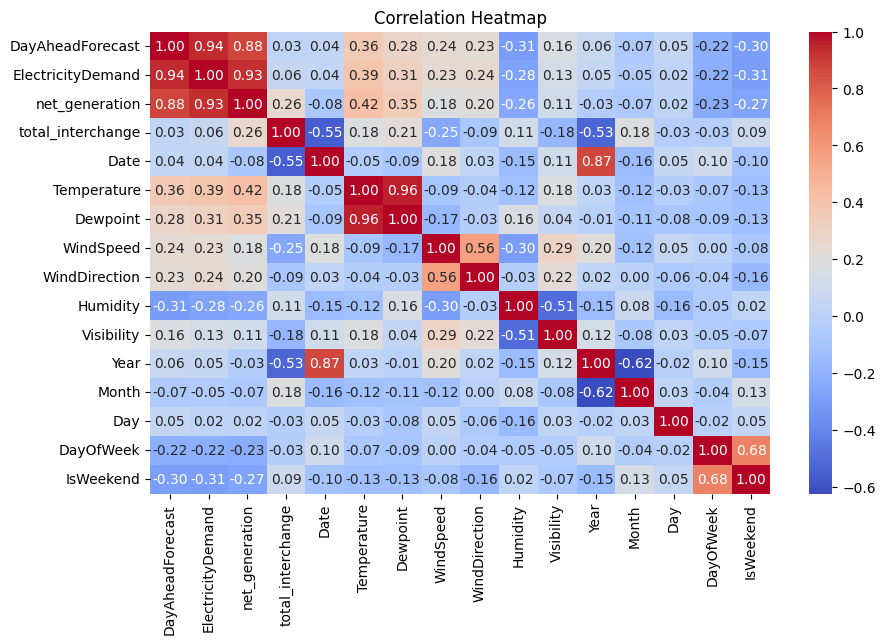

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='ElectricityDemand', data=data)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
features = ['Temperature', 'Humidity', 'WindSpeed', 'Year', 'Month', 'Day', 'DayOfWeek', 'IsWeekend']
X = data[features]
y = data['ElectricityDemand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

RMSE: 7542.657139640848
MAE: 4504.516080901856
R2 Score: 0.650281241194978


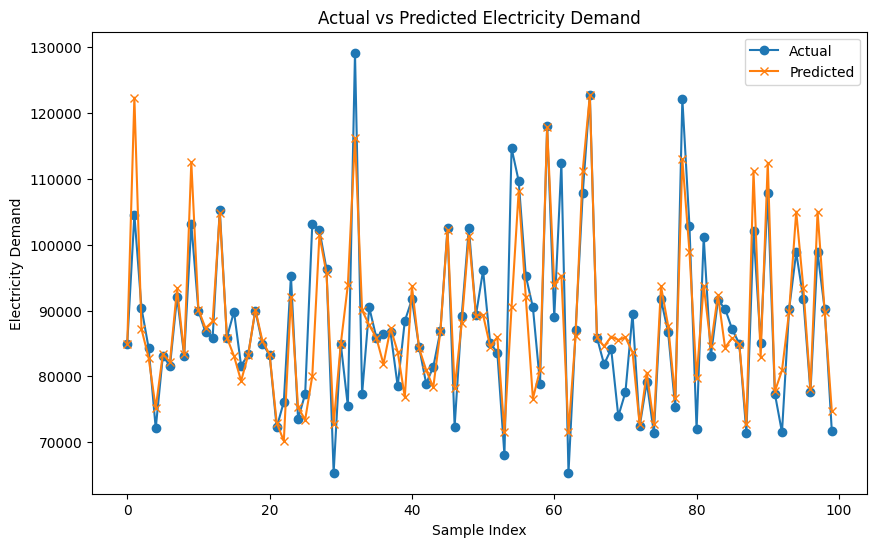

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Sample Index')
plt.ylabel('Electricity Demand')
plt.legend()
plt.show()

# Conclusion:
 The Electricity Consumption Forecasting project successfully demonstrated the integration of electricity demand data and weather conditions for predictive analysis.

 Key findings and outcomes include:
 1. Temperature, humidity, and temporal features were identified as significant predictors of electricity demand.
 2. The Random Forest Regressor model achieved better performance when missing data was dropped compared to imputing missing values.
    - Dropping Null Values:
      RMSE: 6196.02, MAE: 3887.18, R2 Score: 0.79
    - Imputing Null Values:
      RMSE: 7542.66, MAE: 4504.52, R2 Score: 0.65

 This project illustrates the value of integrating weather and temporal data for energy demand forecasting, enabling better energy management and planning decisions. Future improvements could include:
- Exploring advanced models such as LSTMs for capturing temporal dependencies.
- Incorporating additional features like population density or industrial activity levels.
